Setup

This notebook was created and tested on an ml.m4.xlarge notebook instance.

Let's start by specifying:

    The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
    The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
    
Five steps in the code below:
1. Setup
2. Fetch and prepare data
3. Train the model
4. Deploy model
5. Evaluate

### 1. Setup

In [1]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
from sagemaker import Session

bucket = Session().default_bucket()
role = get_execution_role()
prefix = 'sagemaker/DEMO-linear_learner-regress'

In [2]:
bucket

'sagemaker-us-east-1-100038437701'

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

### 2. Fetch and prepare data

In [4]:
df = pd.read_csv('./intlcalls.csv')
df

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Calls,Eve Calls,Night Calls,Intl Calls,CustServ Calls
0,KS,128,415,382-4657,no,yes,25,110,99,91,3,1
1,OH,107,415,371-7191,no,yes,26,123,103,103,3,1
2,NJ,137,415,358-1921,no,no,0,114,110,104,5,0
3,OH,84,408,375-9999,yes,no,0,71,88,89,7,2
4,OK,75,415,330-6626,yes,no,0,113,122,121,3,3
5,AL,118,510,391-8027,yes,no,0,98,101,118,6,0
6,MA,121,510,355-9993,no,yes,24,88,108,118,7,3
7,MO,147,415,329-9001,yes,no,0,79,94,96,6,0
8,LA,117,408,335-4719,no,no,0,97,80,90,4,1
9,WV,141,415,330-8173,yes,yes,37,84,111,97,5,0


In [5]:
df.describe()

,Account Length,Area Code,VMail Message,Day Calls,Eve Calls,Night Calls,Intl Calls,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,100.435644,100.114311,100.107711,4.479448,1.562856
std,39.822106,42.371290,13.688365,20.069084,19.922625,19.568609,2.461214,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,87.000000,87.000000,87.000000,3.000000,1.000000
50%,101.000000,415.000000,0.000000,101.000000,100.000000,100.000000,4.000000,1.000000
75%,127.000000,510.000000,20.000000,114.000000,114.000000,113.000000,6.000000,2.000000
max,243.000000,510.000000,51.000000,165.000000,170.000000,175.000000,20.000000,9.000000


In [6]:
df.corr()["Intl Calls"]

Account Length    0.020661
Area Code        -0.024179
VMail Message     0.013957
Day Calls         0.004574
Eve Calls         0.017434
Night Calls       0.000305
Intl Calls        1.000000
CustServ Calls   -0.017561
Name: Intl Calls, dtype: float64

In [7]:
# feature engineering
df = df.drop('Phone', axis=1)
df['Area Code'] = df['Area Code'].astype(object)

Let's convert our categorical features into numeric features.

In [8]:
data = pd.get_dummies(df)
data = pd.concat([data['Intl Calls'], data.drop(['Intl Calls'], axis=1)], axis=1)

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [9]:
len(data.columns)

65

In [10]:
data.head()

,Intl Calls,Account Length,VMail Message,Day Calls,Eve Calls,Night Calls,CustServ Calls,State_AK,State_AL,State_AR,...,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,3,128,25,110,99,91,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1,3,107,26,123,103,103,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,5,137,0,114,110,104,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
3,7,84,0,71,88,89,2,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,3,75,0,113,122,121,3,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [11]:
model_data = np.array(data.iloc[:, 1:])

In [12]:
target = np.array(data.iloc[:, 0])

In [13]:
model_data.shape, target.shape

((3333, 64), (3333,))

In [14]:
split_train = int(len(model_data) * 0.6)
split_test = int(len(model_data) * 0.8)

In [15]:
train_y = target[:split_train]
train_X = model_data[:split_train, ]
validation_y = target[split_train:split_test]
validation_X = model_data[split_train:split_test, ]
test_y = target[split_test:]
test_X = model_data[split_test:, ]

In [16]:
import sagemaker.amazon.common as smac
# https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/amazon/common.py
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-100038437701/sagemaker/DEMO-linear_learner-regress/train/linear_train.data


In [17]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(validation_X).astype('float32'), np.array(validation_y).astype('float32'))
buf.seek(0)

key = 'linear_validation.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-us-east-1-100038437701/sagemaker/DEMO-linear_learner-regress/validation/linear_validation.data


In [18]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(test_X).astype('float32'), np.array(test_y).astype('float32'))
buf.seek(0)

key = 'linear_test.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded test data location: {}'.format(s3_test_data))

uploaded test data location: s3://sagemaker-us-east-1-100038437701/sagemaker/DEMO-linear_learner-regress/test/linear_test.data


### 3. Training model

In [20]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner') #containers[boto3.Session().region_name]

Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

Create an instance of the sagemaker.estimator.Estimator class. 

In [22]:
from time import gmtime, strftime
model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         sagemaker_session=sagemaker.Session())

Set the hyperparameter values for xgboost

In [23]:
model.set_hyperparameters(feature_dim=64,
                           predictor_type='regressor',
                           normalize_data=False)

To start model training, call the estimator's fit method. 

In [24]:
model.fit({'train': s3_train_data, 'validation': s3_validation_data})

2019-09-22 22:34:58 Starting - Starting the training job...
2019-09-22 22:35:00 Starting - Launching requested ML instances......
2019-09-22 22:36:04 Starting - Preparing the instances for training......
2019-09-22 22:37:06 Downloading - Downloading input data...
2019-09-22 22:37:55 Training - Training image download completed. Training in progress.
2019-09-22 22:37:55 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[09/22/2019 22:37:52 INFO 140540980332352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method'


2019-09-22 22:38:02 Completed - Training job completed
Billable seconds: 57



### Plotting evaluation metrics
Evaluation metrics for the completed training job are available in CloudWatch. We can pull the area under curve metric for the validation data set and plot it to see the performance of the model over time.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


   timestamp                      metric_name         value
0        0.0                   train:progress     63.000000
1        0.0             train:objective_loss      1.312154
2        0.0        validation:objective_loss      7.078142
3        0.0  validation:objective_loss:final      5.207825
4        0.0                   validation:mse      5.207825
5        0.0                 train:throughput  20546.992188
6        0.0         validation:absolute_loss      1.799840


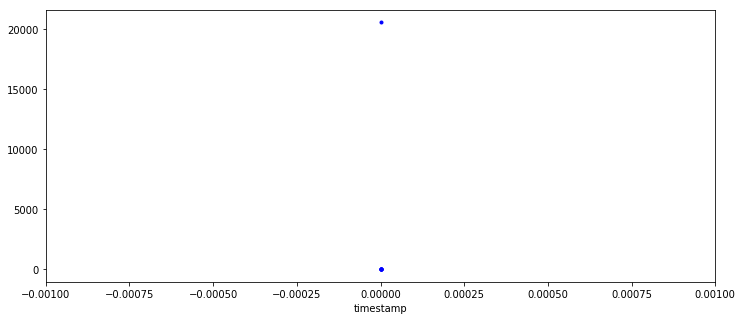

In [25]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

job_name = model._current_job_name
#print(job_name)

#metric_name = 'validation:rmse'
#metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()

metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name).dataframe()
print(metrics_dataframe)

plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
#plt.set_ylabel(metric_name);

### 4. Deploy the model
Deploy the model that you trained in Create and Run a Training Job (Amazon SageMaker Python SDK) by calling the deploy method of the sagemaker.estimator.Estimator object. This is the same object that you used to train the model. When you call the deploy method, specify the number and type of ML instances that you want to use to host the endpoint. 

In [26]:
predictor = model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                )

---------------------------------------------------------------------------------------!

### 5. Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request. But first, we'll need to setup serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.

In [27]:
from sagemaker.predictor import csv_serializer, json_deserializer
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

Now, we'll use a simple function to:

    Loop over our test dataset
    Split it into mini-batches of rows
    Convert those mini-batchs to CSV string payloads
    Retrieve mini-batch predictions by invoking the XGBoost endpoint
    Collect predictions and convert from the CSV output our model provides into a NumPy array

In [28]:
result = predictor.predict(test_X)

In [29]:
result

{'predictions': [{'score': 4.862040042877197},
  {'score': 4.662256717681885},
  {'score': 4.82813835144043},
  {'score': 4.428428649902344},
  {'score': 4.761662483215332},
  {'score': 4.200909614562988},
  {'score': 4.085197925567627},
  {'score': 4.452042579650879},
  {'score': 4.499850273132324},
  {'score': 4.408645153045654},
  {'score': 4.4862260818481445},
  {'score': 4.504484176635742},
  {'score': 4.74680233001709},
  {'score': 4.722764015197754},
  {'score': 5.1593194007873535},
  {'score': 4.11605978012085},
  {'score': 4.569330215454102},
  {'score': 4.135353088378906},
  {'score': 4.518150806427002},
  {'score': 4.446290493011475},
  {'score': 5.126340866088867},
  {'score': 4.970259189605713},
  {'score': 4.193610191345215},
  {'score': 4.514876365661621},
  {'score': 4.667906761169434},
  {'score': 4.238985061645508},
  {'score': 4.674844264984131},
  {'score': 4.543993949890137},
  {'score': 4.475875377655029},
  {'score': 4.451429843902588},
  {'score': 4.650423526763

In [30]:
pred_y = np.array([r['score'] for r in result['predictions']])
pred_y
rmse = np.sqrt(np.mean((pred_y-test_y)**2))
rmse

2.593569281197876

In [31]:
pd.DataFrame(pred_y, test_y)

,0
2,4.862040
4,4.662257
4,4.828138
2,4.428429
6,4.761662
5,4.200910
10,4.085198
5,4.452043
6,4.499850
9,4.408645


Clean-up¶

If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)